In [1]:
%pip install bloom_filter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import torch.optim as optim
import tqdm as tq
from bloom_filter import BloomFilter


In [3]:
total_examples = 50000
good_examples = 25000
# cv_good=2500
# test_good=2500
bad_examples = 25000
# cv_bad=2500
# test_bad=2500
max_length=2100

In [4]:
def generate_dataset():
  df=pd.read_csv("/content/drive/MyDrive/test_input.txt")
  df['label']=(df['label']=='good')*1
  df1 = df[df['label'] == 0]
  df2 = df[df['label'] == 1]
  good_data = df2.head(good_examples)
  bad_data = df1.head(bad_examples)
  return good_data.to_numpy(),bad_data.to_numpy()

def tokenize(data):
  tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK') 
  alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
  d={}
  for i in range(len(alphabet)):
    d[alphabet[i]]=i+1
  d[tk.oov_token]=0
  tk.word_index=d
  data_url=[url.lower() for url in data]
  data_url=tk.texts_to_sequences(data_url)
  data_url=pad_sequences(data_url,maxlen=max_length,padding='post')
  data_url=np.array(data_url,dtype=np.float32)
  return data_url
 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
good_data,bad_data = generate_dataset()
data_train=np.concatenate((good_data,bad_data),axis=0)
np.random.shuffle(data_train)
url_train=data_train[:,0]
url_train_ans=data_train[:,1]
url_train=tokenize(url_train)
url_train=url_train.astype("float32")
url_train_ans=url_train_ans.astype("float32")
url_train=torch.tensor(url_train)
url_train_ans=torch.tensor(url_train_ans)
url_train=url_train.to('cuda')
url_train_ans=url_train_ans.to('cuda')

# data_cv=np.concatenate((good_data[good_examples:good_examples+cv_good],bad_data[bad_examples:bad_examples+cv_bad]),axis=0)
# np.random.shuffle(data_cv)
# url_cv=data_cv[:,0]
# url_cv_ans=data_cv[:,1]
# url_cv=tokenize(url_cv)
# url_cv=url_cv.astype("float32")
# url_cv_ans=url_cv_ans.astype("float32")
# url_cv=torch.tensor(url_cv)
# url_cv_ans=torch.tensor(url_cv_ans)


# data_test=np.concatenate((good_data[good_examples+cv_good:good_examples+cv_good+test_good],bad_data[bad_examples+cv_bad:bad_examples+cv_bad+test_bad]),axis=0)
# np.random.shuffle(data_test)
# url_test=data_test[:,0]
# url_test_ans=data_test[:,1]
# url_test=tokenize(url_test)
# url_test=url_test.astype("float32")
# url_test_ans=url_test_ans.astype("float32")
# url_test=torch.tensor(url_test)
# url_test_ans=torch.tensor(url_test_ans)



In [7]:
class Net_2HL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(max_length,1050)
    self.fc1=nn.Linear(1050,500)
    self.fc2=nn.Linear(500,250)
    self.fc3=nn.Linear(250,125)
    self.fc4=nn.Linear(125,1)
  
  def forward(self, X):
    Op_1=F.relu(self.fc(X))
    Op_2=F.relu(self.fc1(Op_1))
    Op_3=F.relu(self.fc2(Op_2))
    Op_4=F.relu(self.fc3(Op_3))
    Op_5=torch.sigmoid(self.fc4(Op_4))
    return Op_5


In [8]:
def train_dataset(net,train_input,train_ans,examples,lr=1e-2,batch_size=500,epochs=100):
  optimizer = optim.Adam(net.parameters(),lr =lr)
  train_loss = []
  cv_loss = []

  for e in tq.tqdm(range(epochs)):
    epoch_loss = 0
    for b in range(int(examples/batch_size)):
      
      x = train_input[b*batch_size:(b+1)*batch_size]
      y = train_ans[b*batch_size:(b+1)*batch_size]
      out = net(x.view(-1,max_length))
      loss= F.binary_cross_entropy(out.view(-1),y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    epoch_loss = epoch_loss/int(examples/batch_size)
    train_loss.append(epoch_loss)  
    print(epoch_loss)

  plt.plot(np.arange(epochs),train_loss,label = 'Train')
  plt.xlabel('Epochs')
  plt.ylabel('Average Epoch MSE Loss')
  plt.legend()
  plt.title('Loss vs Epochs')
  plt.show()


  1%|          | 1/100 [00:00<01:24,  1.17it/s]

0.924196412563324


  2%|▏         | 2/100 [00:01<01:16,  1.28it/s]

0.392042308151722


  3%|▎         | 3/100 [00:02<01:13,  1.32it/s]

0.3589717036485672


  4%|▍         | 4/100 [00:03<01:11,  1.34it/s]

0.33773822218179705


  5%|▌         | 5/100 [00:03<01:10,  1.35it/s]

0.3264950749278068


  6%|▌         | 6/100 [00:04<01:09,  1.36it/s]

0.31958750516176226


  7%|▋         | 7/100 [00:05<01:08,  1.36it/s]

0.32153494745492933


  8%|▊         | 8/100 [00:05<01:07,  1.37it/s]

0.31513696670532226


  9%|▉         | 9/100 [00:06<01:06,  1.37it/s]

0.30971704572439196


 10%|█         | 10/100 [00:07<01:05,  1.36it/s]

0.3051601031422615


 11%|█         | 11/100 [00:08<01:05,  1.37it/s]

0.2957932524383068


 12%|█▏        | 12/100 [00:08<01:04,  1.37it/s]

0.2961624775826931


 13%|█▎        | 13/100 [00:09<01:03,  1.37it/s]

0.296323761343956


 14%|█▍        | 14/100 [00:10<01:02,  1.37it/s]

0.2968364618718624


 15%|█▌        | 15/100 [00:11<01:02,  1.36it/s]

0.2875973565876484


 16%|█▌        | 16/100 [00:11<01:01,  1.36it/s]

0.28208519145846367


 17%|█▋        | 17/100 [00:12<01:00,  1.36it/s]

0.27395843595266345


 18%|█▊        | 18/100 [00:13<01:00,  1.37it/s]

0.2733447588980198


 19%|█▉        | 19/100 [00:14<00:59,  1.37it/s]

0.2783349294960499


 20%|██        | 20/100 [00:14<00:58,  1.37it/s]

0.2695187596976757


 21%|██        | 21/100 [00:15<00:57,  1.37it/s]

0.26872229248285295


 22%|██▏       | 22/100 [00:16<00:57,  1.37it/s]

0.2701304464042187


 23%|██▎       | 23/100 [00:16<00:56,  1.37it/s]

0.2649999848008156


 24%|██▍       | 24/100 [00:17<00:55,  1.36it/s]

0.25999665319919585


 25%|██▌       | 25/100 [00:18<00:55,  1.36it/s]

0.2553933262825012


 26%|██▌       | 26/100 [00:19<00:54,  1.36it/s]

0.25798297867178915


 27%|██▋       | 27/100 [00:19<00:53,  1.37it/s]

0.2531361158192158


 28%|██▊       | 28/100 [00:20<00:52,  1.37it/s]

0.2564465335011482


 29%|██▉       | 29/100 [00:21<00:52,  1.36it/s]

0.2522596603631973


 30%|███       | 30/100 [00:22<00:51,  1.37it/s]

0.2554386505484581


 31%|███       | 31/100 [00:22<00:50,  1.37it/s]

0.26259113505482673


 32%|███▏      | 32/100 [00:23<00:49,  1.37it/s]

0.25040223211050033


 33%|███▎      | 33/100 [00:24<00:48,  1.37it/s]

0.2499494318664074


 34%|███▍      | 34/100 [00:24<00:48,  1.37it/s]

0.25097295552492144


 35%|███▌      | 35/100 [00:25<00:47,  1.37it/s]

0.2473241390287876


 36%|███▌      | 36/100 [00:26<00:48,  1.32it/s]

0.24920235574245453


 37%|███▋      | 37/100 [00:27<00:48,  1.29it/s]

0.24830268770456315


 38%|███▊      | 38/100 [00:28<00:48,  1.28it/s]

0.2431950533390045


 39%|███▉      | 39/100 [00:28<00:46,  1.30it/s]

0.24703790754079819


 40%|████      | 40/100 [00:29<00:45,  1.32it/s]

0.24492118015885353


 41%|████      | 41/100 [00:30<00:44,  1.34it/s]

0.24624066904187203


 42%|████▏     | 42/100 [00:31<00:43,  1.35it/s]

0.24828779503703116


 43%|████▎     | 43/100 [00:31<00:42,  1.35it/s]

0.24420235708355903


 44%|████▍     | 44/100 [00:32<00:41,  1.36it/s]

0.24103910133242606


 45%|████▌     | 45/100 [00:33<00:40,  1.36it/s]

0.23844886392354966


 46%|████▌     | 46/100 [00:33<00:39,  1.36it/s]

0.24110650688409804


 47%|████▋     | 47/100 [00:34<00:38,  1.37it/s]

0.24161809384822847


 48%|████▊     | 48/100 [00:35<00:38,  1.36it/s]

0.23895011931657792


 49%|████▉     | 49/100 [00:36<00:37,  1.37it/s]

0.23921005591750144


 50%|█████     | 50/100 [00:36<00:36,  1.36it/s]

0.2368946649134159


 51%|█████     | 51/100 [00:37<00:35,  1.36it/s]

0.2399254807829857


 52%|█████▏    | 52/100 [00:38<00:35,  1.36it/s]

0.2313281224668026


 53%|█████▎    | 53/100 [00:39<00:34,  1.36it/s]

0.23124366596341134


 54%|█████▍    | 54/100 [00:39<00:33,  1.36it/s]

0.2310242010653019


 55%|█████▌    | 55/100 [00:40<00:32,  1.36it/s]

0.23039650306105613


 56%|█████▌    | 56/100 [00:41<00:32,  1.37it/s]

0.22981127858161926


 57%|█████▋    | 57/100 [00:42<00:31,  1.37it/s]

0.22641745939850808


 58%|█████▊    | 58/100 [00:42<00:30,  1.37it/s]

0.23129921212792395


 59%|█████▉    | 59/100 [00:43<00:30,  1.36it/s]

0.2258913090825081


 60%|██████    | 60/100 [00:44<00:29,  1.37it/s]

0.2239823591709137


 61%|██████    | 61/100 [00:44<00:28,  1.37it/s]

0.22560950219631196


 62%|██████▏   | 62/100 [00:45<00:29,  1.27it/s]

0.2232591962814331


 63%|██████▎   | 63/100 [00:46<00:30,  1.20it/s]

0.22578870251774788


 64%|██████▍   | 64/100 [00:47<00:32,  1.12it/s]

0.22036455929279328


 65%|██████▌   | 65/100 [00:48<00:32,  1.07it/s]

0.22739505097270013


 66%|██████▌   | 66/100 [00:49<00:29,  1.14it/s]

0.22563809871673585


 67%|██████▋   | 67/100 [00:50<00:27,  1.20it/s]

0.22382067739963532


 68%|██████▊   | 68/100 [00:51<00:25,  1.25it/s]

0.2209426210820675


 69%|██████▉   | 69/100 [00:51<00:24,  1.28it/s]

0.23815468788146973


 70%|███████   | 70/100 [00:52<00:22,  1.31it/s]

0.22131373435258866


 71%|███████   | 71/100 [00:53<00:21,  1.32it/s]

0.21441027909517288


 72%|███████▏  | 72/100 [00:54<00:20,  1.34it/s]

0.22074474528431892


 73%|███████▎  | 73/100 [00:54<00:20,  1.35it/s]

0.225514525026083


 74%|███████▍  | 74/100 [00:55<00:19,  1.35it/s]

0.22308591306209563


 75%|███████▌  | 75/100 [00:56<00:18,  1.35it/s]

0.22140035808086395


 76%|███████▌  | 76/100 [00:56<00:17,  1.35it/s]

0.22261280730366706


 77%|███████▋  | 77/100 [00:57<00:16,  1.36it/s]

0.23319113224744797


 78%|███████▊  | 78/100 [00:58<00:16,  1.36it/s]

0.2327330830693245


 79%|███████▉  | 79/100 [00:59<00:15,  1.36it/s]

0.22156890600919724


 80%|████████  | 80/100 [00:59<00:14,  1.36it/s]

0.22635479375720025


 81%|████████  | 81/100 [01:00<00:13,  1.36it/s]

0.22524797901511193


 82%|████████▏ | 82/100 [01:01<00:13,  1.36it/s]

0.2265825690329075


 83%|████████▎ | 83/100 [01:02<00:12,  1.37it/s]

0.21975201070308686


 84%|████████▍ | 84/100 [01:02<00:11,  1.37it/s]

0.22078240111470224


 85%|████████▌ | 85/100 [01:03<00:10,  1.37it/s]

0.23858181044459342


 86%|████████▌ | 86/100 [01:04<00:10,  1.37it/s]

0.24801364973187445


 87%|████████▋ | 87/100 [01:05<00:09,  1.37it/s]

0.2246157482266426


 88%|████████▊ | 88/100 [01:05<00:08,  1.37it/s]

0.2236079207062721


 89%|████████▉ | 89/100 [01:06<00:08,  1.37it/s]

0.21490195274353027


 90%|█████████ | 90/100 [01:07<00:07,  1.37it/s]

0.21224284812808036


 91%|█████████ | 91/100 [01:07<00:06,  1.37it/s]

0.21638958320021628


 92%|█████████▏| 92/100 [01:08<00:05,  1.37it/s]

0.21657991662621498


 93%|█████████▎| 93/100 [01:09<00:05,  1.37it/s]

0.222876897752285


 94%|█████████▍| 94/100 [01:10<00:04,  1.37it/s]

0.20818902999162675


 95%|█████████▌| 95/100 [01:10<00:03,  1.37it/s]

0.21081366539001464


 96%|█████████▌| 96/100 [01:11<00:02,  1.37it/s]

0.20399894520640374


 97%|█████████▋| 97/100 [01:12<00:02,  1.37it/s]

0.20513701260089875


 98%|█████████▊| 98/100 [01:13<00:01,  1.37it/s]

0.20138641342520713


 99%|█████████▉| 99/100 [01:13<00:00,  1.37it/s]

0.2065531787276268


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]

0.21068642675876617


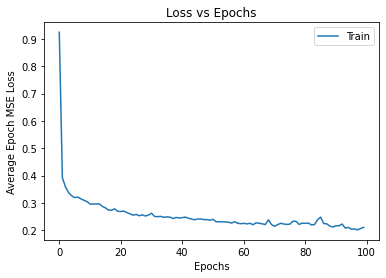

In [10]:
net=Net_2HL()
net.to('cuda')
train_dataset(net,url_train,url_train_ans,good_examples+bad_examples)

In [11]:
def test(net,test_input):
  out=net(test_input.view(-1,max_length))
  return out

random_idx=np.random.randint(0,total_examples,7000)
test_input=url_train[random_idx]
test_ans=url_train_ans[random_idx]
out=test(net,test_input)
print(F.binary_cross_entropy(out.view(-1),test_ans))
print(torch.sum(((out>=0.5)*1).view(-1) == test_ans)/7000)

tensor(0.2225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8976, device='cuda:0')


In [12]:
def Train_Bloom_Filter(bloom,net,train_input,train_input_tokens,train_ans,tau):
    out=net(train_input_tokens.view(-1,max_length))
    out=out.view(-1).cpu().detach().numpy()
    train_ans=train_ans.cpu().numpy()
    add_to_bloom=train_input[(out<tau) & (train_ans==1)]
    for i in range(len(add_to_bloom)):
      bloom.add(add_to_bloom[i])
    return bloom

def Test_Learned_Bloom_Filter(net,bloom,data,tau,out):
    out_learned=np.zeros(len(data))
    for i in range(len(data)):
        if out[i]>tau:
            out_learned[i]=1
        elif data[i] in bloom:
            out_learned[i]=1
    return out_learned

def Test_Sandwich_Bloom_Filter(net,bloom1,bloom2,data,tau,out):
    out_learned = np.zeros(len(data))
    for i in range(len(data)):
      if data[i] not in bloom1:
        continue
      else:
        if out[i] > tau:
          out_learned[i] = 1
        elif data[i] in bloom2:
          out_learned[i] = 1
    return out_learned

def Test_Bloom_Filter(bloom1, test_data):
  out_bloom = np.zeros(len(test_data))
  for i in range(len(test_data)):
    if test_data[i] in bloom1:
      out_bloom[i]=1
  return out_bloom

In [21]:
error_rates = [0.01*i for i in range(1,11)]
tau = 0.9

learn_accuracy = []
bloom_accuracy = []
sandwich_accuracy = []

for er in tq.tqdm(range(len(error_rates))):
  bloom1 = BloomFilter(max_elements=25000, error_rate=error_rates[er])
  bloom2 = BloomFilter(max_elements=25000, error_rate=error_rates[er])

  data_good=data_train[data_train[:,1]==1]

  for i in range(len(data_good)):
    bloom1.add(data_good[i][0])
  bloom2=Train_Bloom_Filter(bloom2,net,data_train[:,0],url_train,url_train_ans,tau)

  test_data = data_train[:,0]
  test_data_tokens=url_train
  test_ans=url_train_ans
  out=test(net,test_data_tokens)
  y_pred_normal= Test_Learned_Bloom_Filter(net,bloom2,test_data,tau,out)
  y_pred_bloom = Test_Bloom_Filter(bloom1,test_data)
  y_pred_sandwich = Test_Sandwich_Bloom_Filter(net,bloom1,bloom2,test_data,tau,out)
  print(sum(abs(y_pred_normal-test_ans.cpu().numpy())),sum(abs(y_pred_bloom-test_ans.cpu().numpy())))
  learn_accuracy.append(1-sum(abs(y_pred_normal-test_ans.cpu().numpy()))/total_examples)
  bloom_accuracy.append(1-sum(abs(y_pred_bloom-test_ans.cpu().numpy()))/total_examples)
  sandwich_accuracy.append(1-sum(abs(y_pred_sandwich-test_ans.cpu().numpy()))/total_examples)
  
learn_accuracy = np.array(learn_accuracy)
bloom_accuracy = np.array(bloom_accuracy)
sandwich_accuracy = np.array(sandwich_accuracy)

 10%|█         | 1/10 [00:18<02:49, 18.83s/it]

92.0 288.0


 20%|██        | 2/10 [00:35<02:20, 17.59s/it]

104.0 480.0


 30%|███       | 3/10 [00:52<02:02, 17.46s/it]

110.0 735.0


 40%|████      | 4/10 [01:09<01:42, 17.15s/it]

124.0 1024.0


 50%|█████     | 5/10 [01:26<01:25, 17.19s/it]

156.0 1301.0


 60%|██████    | 6/10 [01:43<01:07, 16.98s/it]

165.0 1530.0


 70%|███████   | 7/10 [02:01<00:51, 17.25s/it]

226.0 1758.0


 80%|████████  | 8/10 [02:18<00:34, 17.39s/it]

232.0 1996.0


 90%|█████████ | 9/10 [02:35<00:17, 17.16s/it]

279.0 2329.0


100%|██████████| 10/10 [02:52<00:00, 17.20s/it]

335.0 2589.0


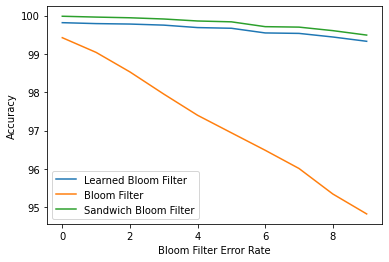

In [22]:
plt.plot(np.arange(len(learn_accuracy)),learn_accuracy*100,label = 'Learned Bloom Filter')
plt.plot(np.arange(len(bloom_accuracy)),bloom_accuracy*100,label = 'Bloom Filter')
plt.plot(np.arange(len(sandwich_accuracy)),sandwich_accuracy*100,label = 'Sandwich Bloom Filter')
plt.legend()
plt.xlabel('Bloom Filter Error Rate')
plt.ylabel('Accuracy')
plt.show()